In [1]:
import numpy as np
import os 
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.metrics import roc_curve
import sklearn.metrics

from sklearn.model_selection import KFold

from matplotlib import pyplot as plt

In [2]:
def readFiles(fileloc):
    features = list()
    filenames = list()
    maxshapes = list()
    
    for filename in os.listdir(fileloc):
        curr = np.load(f"{fileloc}/{filename}")
        f_name = filename[0:14].strip()
        if f_name == "S12_Day2_Part3" or f_name == "S13_Day1_Part1" or f_name == "": continue
        features.append(curr)
        filenames.append(filename)
        maxshapes.append(curr.shape[0])
    
    ms = max(maxshapes)
    print(ms)
    for f in range(len(features)):
        features[f] = np.resize(features[f], (ms, 32))

    # for f in features: print(f.shape)
    print(len(features))
    return features, filenames

features, filenames = readFiles("features")
        

537
111


In [3]:
S10_Day1_pt1 = [0, 1, 0, 0, 1, 0, 1, 0, 0, 0] # 10
S10_day2_pt1 = [0, 0, 1, 1, 1, 1, 0, 1, 1, 1] # 10
S10_day3_pt1 = [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0] # 13

# S11_Day1_pt1 = [] This is missing from Feature Vectors
S11_day3_pt1 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] # 12

S12_day1_pt1 = [1, 0, 0, 0, 1, 1, 1, 1, 1, 1] # 10
S12_day2_pt1 = [1, 1, 1, 1, 0, 1, 1, 1, 1, 1] # 10
# S12_day2_pt3 = [] This is missing from Feature Vectors
S12_day3_pt3 = [0, 0, 0, 0, 0, 0, 0] # 7

# S13_Day1_pt2 = [] This is missing from Feature Vectors ToT

S9_day1_pt1 = [0, 0, 0, 1, 1, 1] # 6
S9_day2_pt1 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] # 10

S8_Day1_pt1 = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] # 10

S18_Day3_pt1 = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0] # 13




ground_truth = S10_Day1_pt1 + S10_day2_pt1 + S10_day3_pt1 + S11_day3_pt1 + S12_day1_pt1 + S12_day2_pt1 + S12_day3_pt3 + S9_day1_pt1 + S9_day2_pt1 + S8_Day1_pt1 + S18_Day3_pt1
print(len(ground_truth), len(features))



111 111


In [4]:
#Creates CNN Class and creates model you will use
#tests model with a random array to make sure that it outputs correct dims

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork_Conv(nn.Module):
    def __init__(self):
        super(NeuralNetwork_Conv, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv1d(537, 100, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(100, 2, 3, stride=1, padding=1),
            nn.ReLU(),
            # nn.MaxPool1d(2),
            # nn.Conv1d(32, 32, 3, stride=1, padding=1),
            # nn.ReLU(),
        )
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 2),
            # nn.ReLU(),
            # nn.Linear(50, 2),
        )

    def forward(self, x):
        logits = self.fc_stack(self.conv_stack(x))
        return logits

# initializes model
model = NeuralNetwork_Conv().to(device)

print(model)
for p in model.parameters():
    print(p.size())

#tests if model outputs correct dimensions 
mb = torch.rand(10, 537, 32).to(device)
logits = model.forward(mb)


Using cuda device
NeuralNetwork_Conv(
  (conv_stack): Sequential(
    (0): Conv1d(537, 100, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(100, 2, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
  )
  (fc_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32, out_features=2, bias=True)
  )
)
torch.Size([100, 537, 3])
torch.Size([100])
torch.Size([2, 100, 3])
torch.Size([2])
torch.Size([2, 32])
torch.Size([2])


In [5]:
#Displays Loss Function

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [6]:
#Performance Metrics
#assumption: input list of pairs is given as (actual_class, predicted_class)

def compute_accuracy(test_pairs, num_classes):
    #Computes Percent of predictions that are accurate
    test_p = np.array(test_pairs)
    
    #Gets number of pairs that have the same number for each element in the pair and calculates percentage
    right = np.sum(test_p[:, 0] == test_p[:, 1])
    return (right/len(test_pairs))*100

def compute_per_class_accuracy(test_pairs, num_classes):
    #Gets Percent of accurate guesses but for classes. So for class 1, it is (# of accurate Class 1 Guesses)/(Total Guesses)
    test_pairs = np.array(test_pairs)
    
    #the ith element of rightClass holds the number of correct guesses for class i
    rightClass = np.array([0]*num_classes)
    total = np.array([0]*num_classes)
    np.add.at(total, test_pairs[:, 0], 1)
    
    #creates map and uses it to filter out number of pairs that are correct
    tp_map = test_pairs[:,0] == test_pairs[:, 1]
    tps = test_pairs[tp_map]
    
    #puts the number of correct guesses for each class into its appropriate element in the rightClass array and calculates percentage for each class
    np.add.at(rightClass, tps[:, 0], 1)
    arr = (rightClass/total)
    
    return arr

def compute_confusion_matrix(test_pairs, num_classes):
    #Computed confusion matrix 
    conf_mat = np.zeros((num_classes, num_classes), dtype=int)
    test_pairs = np.array(test_pairs)
    
    #incremenets 1 in the appropriate element in matrix to indicate that the first pair element was the actual class and second was the guess
    np.add.at(conf_mat, (test_pairs[:, 0], test_pairs[:, 1]), 1)
    
    return conf_mat

In [7]:
print(len(ground_truth), len(features))
ground_truth = np.array(ground_truth)
ground_truth_tensor = torch.tensor(ground_truth).to('cuda').to(torch.int64)
features = torch.tensor(features).to('cuda')
final_conf_matrix = np.zeros((2,2))
elems = list()
avg_test_loss = 0
kf = KFold(n_splits=25, shuffle=True)
for i, (train_index, test_index) in enumerate(kf.split(features)):
    model.train()
    training_data = features[train_index, :]
    training_gt = ground_truth_tensor[train_index]
    
    pred = model(training_data)
    # print(pred.argmax(1), training_gt)
    loss = loss_fn(pred, training_gt)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    testing_data = features[test_index, :]
    testing_gt = ground_truth_tensor[test_index]
    t_pred = model(testing_data)
    t_loss = loss_fn(t_pred, testing_gt)
    avg_test_loss += t_loss
    print(f"Testing Loss: {t_loss.item()}")
    gt = ground_truth[test_index]
    tp = t_pred.argmax(1).detach().cpu().numpy()
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true=gt,y_pred=tp, labels=[0, 1])
    final_conf_matrix += confusion_matrix
    elems1 = np.stack((gt, tp), axis=-1).tolist()
    
    elems += elems1   
    
    print(f"Fold {i}:")
    print(f"  Train: index={training_data.shape}")
    print(f"  Test:  index={testing_data.shape}")

final_conf_matrix /= 25 
elems = np.array(elems)
avg_test_loss /= 25



111 111


C:\Users\SUNDAS9\AppData\Local\Temp\ipykernel_8052\3407392765.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  features = torch.tensor(features).to('cuda')


Testing Loss: 0.6473833918571472
Fold 0:
  Train: index=torch.Size([106, 537, 32])
  Test:  index=torch.Size([5, 537, 32])
Testing Loss: 0.6787186861038208
Fold 1:
  Train: index=torch.Size([106, 537, 32])
  Test:  index=torch.Size([5, 537, 32])
Testing Loss: 0.5359285473823547
Fold 2:
  Train: index=torch.Size([106, 537, 32])
  Test:  index=torch.Size([5, 537, 32])
Testing Loss: 0.6336643695831299
Fold 3:
  Train: index=torch.Size([106, 537, 32])
  Test:  index=torch.Size([5, 537, 32])
Testing Loss: 0.596835732460022
Fold 4:
  Train: index=torch.Size([106, 537, 32])
  Test:  index=torch.Size([5, 537, 32])
Testing Loss: 0.5147377252578735
Fold 5:
  Train: index=torch.Size([106, 537, 32])
  Test:  index=torch.Size([5, 537, 32])
Testing Loss: 0.5494025945663452
Fold 6:
  Train: index=torch.Size([106, 537, 32])
  Test:  index=torch.Size([5, 537, 32])
Testing Loss: 0.48343706130981445
Fold 7:
  Train: index=torch.Size([106, 537, 32])
  Test:  index=torch.Size([5, 537, 32])
Testing Loss: 0.

Testing Statistics:

Average Testing Loss:  0.41
Accuracy: 87.39%

Per class accuracy
0: 0.72%
1: 0.98%

Total Confusion matrix
 0:  34  13
 1:   1  63


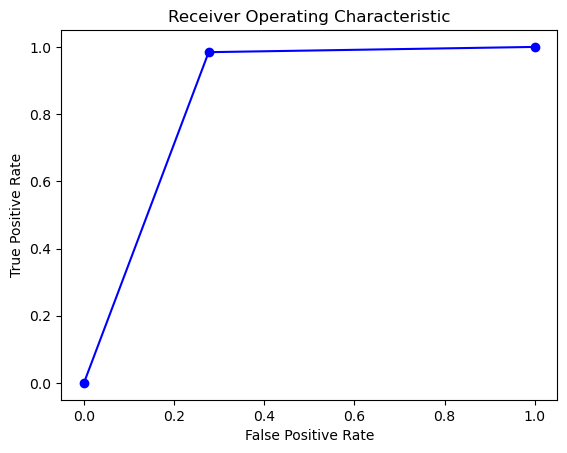

<Figure size 640x480 with 0 Axes>

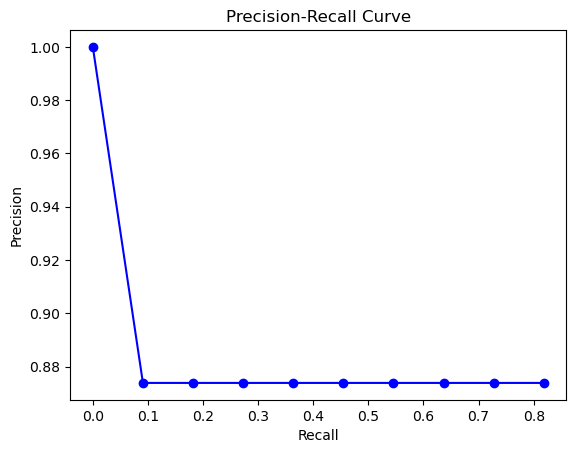

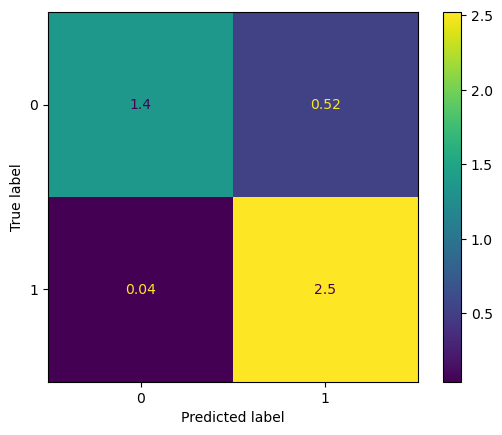

<Figure size 640x480 with 0 Axes>

In [8]:

#gets testing statistics
acc = compute_accuracy(elems, 2)
classacc = compute_per_class_accuracy(elems, 2)
confmat = compute_confusion_matrix(elems, 2)

print("Testing Statistics:\n")

print(f"Average Testing Loss: {avg_test_loss: .2f}")
#outputs accuracy, per class accuracy, and confusion matrix
print(f'Accuracy: {acc:.2f}%\n')

print('Per class accuracy')
for i, acc in enumerate(classacc):
    print(f'{i}: {acc:4.2f}%')
    
print(f'\nTotal Confusion matrix')
for i in range(2):
    print(f'{i:2d}:', end='')
    for j in range(2):
        print(f' {confmat[i, j]:3d}', end='')
    print()
    
preds = elems[:, 1]
gts = elems[:, 0]
b = (preds==gts).astype(int)

prec = np.cumsum(b)/np.arange(1, b.shape[0]+1)
recall = np.cumsum(b)/b.shape[0]

rj = np.arange(0, 10)/11

pj = list()
    
for i in rj:
    
    r_map = recall>=i
    curr_map = prec[r_map]
    if curr_map.shape[0]==0: pj.append(0)
    else: pj.append(np.max(curr_map))

fpr, tpr, thresholds = roc_curve(gts, preds)

plt.plot(fpr, tpr, 'bo', linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.figure()
plt.show()

plt.plot(rj, pj, 'bo', linestyle="-")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = final_conf_matrix, display_labels = [0, 1])

cm_display.plot()
plt.figure()
plt.show()
